# Identifying the Risk of COVID-19 and North Atlantic Hurricanes 

**Authors**: Jocelyn Lutes, Quinton Lopez, Uriel Eckmann

## Problem Statement
---
The east coast endures more storms yearly than any other area of the country. The warm temperatures of the Atlantic increase the power of hurricanes. That combined with the common patterns of winds moving east to west after being formed in the eastern Atlantic make threats to residents homes, businesses, and way of life every hurricane season. From June 1st to November 30, citizens must remain aware of hazardous weather conditions except this year, an unexpected global pandemic could cause even more worry. The number of confirmed cases have passed 5 million and deaths have reached over 160,000 in the United States. There is no vaccine created and the close proximity of large groups of people significantly increases the chances of becoming infected. Identifying the areas at risk for Covid-19 and other natural disasters can help provide proper guidance for evacuating families and prevent the further spread of Covid-19. 

In this project, we will use clustering algorithms to attempt to identify clusters based on historical risk for tropical storms and current risk of COVID-19.

## Executive Summary

## Table of Contents
---
- [Imports](#Covid-&-Natural-Disaster-Data-Import)
- [Read-In Hurricane Data](#Read-In-Hurricane-Data)
- [Read-In COVID-19 Data](#Read-In-COVID-19-Data)
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Model Prep](#Model-Prep)
- [Modeling](#Modeling)
- [Conclusion & Recommendation](#Conclusion-&-Recommendation)
- [References](#References)

## Imports

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.figure_factory as ff

RANDOM_STATE = 42

## Read - In Data

For this notebook, we will rely on the hurricane data from IBTrACKS, the COVID-19 data from the New York Times, and the aggregate data that we engineered from these two sources.

### Merge Aggregate Tropical Storms Data with COVID-19 Data

#### Read - In Data

In [7]:
aggregate_storm_data  = pd.read_csv('../data/aggregate_storm_data.csv')
covid_hurricane_states = pd.read_csv('../data/covid_hurricane_states.csv')

#### Merge Data

In [10]:
hurricanes_and_covid = pd.merge(left = aggregate_storm_data, right = covid_hurricane_states[['state', 'county', 'cases', 'deaths', 'previous_cases', 'previous_deaths','2019_population', 'change_in_case_ratio' ]], how = 'left', on = ['state', 'county'])

#### Select Columns

In [12]:
location_info = ['state', 'county']
hurricane_features = ['cat_1_count', 'cat_2_count', 'cat_3_count', 'cat_4_count', 'cat_5_count', 'hurricane_count', 'tropical_storm_count', 'extratropical_system_count', 'tropical_depression_count', 'low_count', 'subtropical_depression_count', 'dissipating_storm_count']
covid_features = ['cases', 'deaths', 'previous_cases', 'previous_deaths','2019_population','change_in_case_ratio']

features_to_keep = location_info + hurricane_features + covid_features

hurricanes_and_covid = hurricanes_and_covid[features_to_keep]

#### Rename Columns

In [48]:
hurricanes_and_covid.rename(columns = {'date_x':'current_date', 
                                         'cases':'current_cases',
                                         'deaths': 'current_deaths',
                                         'cases_per_100000': 'current_cases_per_100000',
                                         'date_y':'one_week_ago_date'}, inplace = True)

In [50]:
hurricanes_and_covid.head()

state    county  cat_1_count  cat_2_count  cat_3_count  cat_4_count  \
0  Texas   Calhoun            2            3            1            0   
1  Texas   Refugio            3            1            2            0   
2  Texas       Bee            1            0            0            0   
3  Texas  Live Oak            0            0            0            0   
4  Texas  McMullen            0            0            0            0   

   cat_5_count  hurricane_count  tropical_storm_count  \
0            0                6                     2   
1            0                6                     5   
2            0                1                     8   
3            0                0                     4   
4            0                1                     7   

   extratropical_system_count  tropical_depression_count  low_count  \
0                           0                          5          0   
1                           0                          1          0   
2                           0                          2          0   
3                           0                          3          0   
4                           0                          7          0   

   subtropical_depression_count  dissipating_storm_count  current_cases  \
0                             0                        0          546.0   
1                             0                        0          234.0   
2                             0                        0         1246.0   
3                             0                        0          230.0   
4                             0                        0            9.0   

   current_deaths  previous_cases  previous_deaths  2019_population  \
0             5.0           493.0              4.0          21290.0   
1             4.0           214.0              0.0           6948.0   
2            11.0           669.0              9.0          32565.0   
3             4.0           207.0              2.0          12207.0   
4             0.0             8.0              0.0            743.0   

   change_in_case_ratio  
0                 249.0  
1                 287.9  
2                1771.8  
3                 188.5  
4                 134.6

### Tropical Storms/ Hurricane Data

In [17]:
geo_df_usa = pd.read_csv('../data/geo_usa.csv')
geo_df_usa.drop(columns = 'Unnamed: 0', inplace = True)
geo_df_usa.head(2)

storm_id  year  number       name             iso_time nature  \
0  1851175N26270  1851     5.0  NOT_NAMED  1851-06-26 00:00:00     TS   
1  1851175N26270  1851     5.0  NOT_NAMED  1851-06-26 03:00:00     TS   

   latitude  longitude  wmo_wind(knots)  wmo_pressure(mb)  ... usa_status  \
0   28.1667   -96.8000             70.0               NaN  ...         HU   
1   28.2265   -97.0793              NaN               NaN  ...         HU   

   usa_wind  usa_pres  storm_category  sea_height(ft) storm_speed(knots)  \
0      70.0       NaN             1.0             NaN                5.0   
1      65.0       NaN             1.0             NaN                5.0   

   storm_direction(degrees)                  geometry  state   county  
0                     282.0     POINT (-96.8 28.1667)  Texas  Calhoun  
1                     284.0  POINT (-97.0793 28.2265)  Texas  Refugio  

[2 rows x 25 columns]

### COVID-19 Data for States with a History of Tropical Storms

In [49]:
covid_hurricane_states = pd.read_csv('../data/covid_hurricane_states.csv')
covid_hurricane_states.head(3)

date_x   county    state    fips  cases  deaths  2019_population  \
0  2020-08-11  Autauga  Alabama  1001.0   1215      23          55869.0   
1  2020-08-11  Baldwin  Alabama  1003.0   3736      32         223234.0   
2  2020-08-11  Barbour  Alabama  1005.0    643       6          24686.0   

   cases_per_100000      date_y  previous_cases  previous_deaths  \
0            2174.7  2020-08-04          1073.0             21.0   
1            1673.6  2020-08-04          3320.0             24.0   
2            2604.7  2020-08-04           614.0              5.0   

   previous_cases_per_100000  change_in_cases  change_in_case_ratio  
0                     1920.6            142.0                 254.1  
1                     1487.2            416.0                 186.4  
2                     2487.2             29.0                 117.5

## Read-In Geopandas Data

### USA - States

In [63]:
usa_states = gpd.read_file('../maps/states_21basic/states.shp')
usa_states.head(1)

STATE_NAME  DRAWSEQ STATE_FIPS SUB_REGION STATE_ABBR  \
0     Hawaii        1         15    Pacific         HI   

                                            geometry  
0  MULTIPOLYGON (((-160.07380 22.00418, -160.0497...

### USA - Counties

In [64]:
usa_counties = gpd.read_file('../maps/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
usa_counties.head(1)

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID    NAME LSAD       ALAND  \
0      37      017  01026336  0500000US37017  37017  Bladen   06  2265887723   

     AWATER                                           geometry  
0  33010866  POLYGON ((-78.90200 34.83527, -78.79960 34.850...

## Data Cleaning

### Aggregate Data

In [15]:
hurricanes_and_covid.isna().sum()

state                            0
county                           0
cat_1_count                      0
cat_2_count                      0
cat_3_count                      0
cat_4_count                      0
cat_5_count                      0
hurricane_count                  0
tropical_storm_count             0
extratropical_system_count       0
tropical_depression_count        0
low_count                        0
subtropical_depression_count     0
dissipating_storm_count          0
cases                           26
deaths                          26
previous_cases                  26
previous_deaths                 26
2019_population                 26
change_in_case_ratio            26
dtype: int64

The null values are missing COVID-19 data so will be dropped.

In [21]:
hurricanes_and_covid.dropna(inplace = True)

### COVID-19 for States with History of Tropical Storms

In [19]:
covid_hurricane_states.isna().sum()

date_x                        0
county                        0
state                         0
fips                         19
cases                         0
deaths                        0
2019_population              19
cases_per_100000             19
date_y                        4
previous_cases                4
previous_deaths               4
previous_cases_per_100000    22
change_in_cases               4
change_in_case_ratio         22
dtype: int64

Many of these cases correspond to "Unknown" counties so will be dropped.

In [27]:
covid_hurricane_states.dropna(inplace = True)

### Historical Data for North Atlantic Tropical Storms/ Hurricanes

In [29]:
geo_df_usa.isna().sum()

storm_id                       0
year                           0
number                         0
name                           0
iso_time                       0
nature                         0
latitude                       0
longitude                      0
wmo_wind(knots)             3801
wmo_pressure(mb)            5726
wmo_agency                  3800
dist2land(km)                  0
landfall(km)                   0
usa_lat                      519
usa_lon                      519
usa_status                   481
usa_wind                     541
usa_pres                    4356
storm_category                94
sea_height(ft)              6980
storm_speed(knots)             0
storm_direction(degrees)       0
geometry                       0
state                          0
county                         0
dtype: int64

Because we will only be using this data for plotting, we will be able to ignore missing values.

## Feature Engineering

### Change in Deaths Ratio

In [89]:
hurricanes_and_covid['change_in_deaths_ratio'] = ((hurricanes_and_covid['current_deaths'] - hurricanes_and_covid['previous_deaths']) / hurricanes_and_covid['2019_population']) * 100_000

In [91]:
hurricanes_and_covid.head(2)

state   county  cat_1_count  cat_2_count  cat_3_count  cat_4_count  \
0  Texas  Calhoun            2            3            1            0   
1  Texas  Refugio            3            1            2            0   

   cat_5_count  hurricane_count  tropical_storm_count  \
0            0                6                     2   
1            0                6                     5   

   extratropical_system_count  ...  dissipating_storm_count  current_cases  \
0                           0  ...                        0          546.0   
1                           0  ...                        0          234.0   

   current_deaths  previous_cases  previous_deaths  2019_population  \
0             5.0           493.0              4.0          21290.0   
1             4.0           214.0              0.0           6948.0   

   change_in_case_ratio  disturbance_composite  storm_composite  \
0                 249.0                     13               13   
1                 287.9                     14               14   

   change_in_deaths_ratio  
0                4.697041  
1               57.570524  

[2 rows x 23 columns]

### Tropical Storm Composite Score

In addition to the aggregate storm feature and COVID-19 features that we have already engineered, we also wanted to engineer a composite feature to capture the overall historical risk of the hurricanes. Because Category 3, Category 4, and Category 5 hurricanes are the most destructive, we also wanted these storms to carry a higher weight in our composite score.

In [86]:
hurricanes_and_covid['storm_composite'] = hurricanes_and_covid['cat_1_count'] + hurricanes_and_covid['cat_2_count'] + (hurricanes_and_covid['cat_3_count'] ** 2) + (hurricanes_and_covid['cat_4_count'] ** 2) + (hurricanes_and_covid['cat_5_count'] ** 2) + hurricanes_and_covid['tropical_storm_count'] + hurricanes_and_covid['tropical_depression_count']
hurricanes_and_covid['storm_composite'].describe()

count    1510.000000
mean        3.645033
std         5.462186
min         0.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        62.000000
Name: storm_composite, dtype: float64

We decided to take the sum of the storms, but to give extra weight to Category 3, Category 4, and Category 5 storms, we squared them.



## Exploratory Data Analysis

### Visualize Tropical Storms That Have Made Landfall in the USA

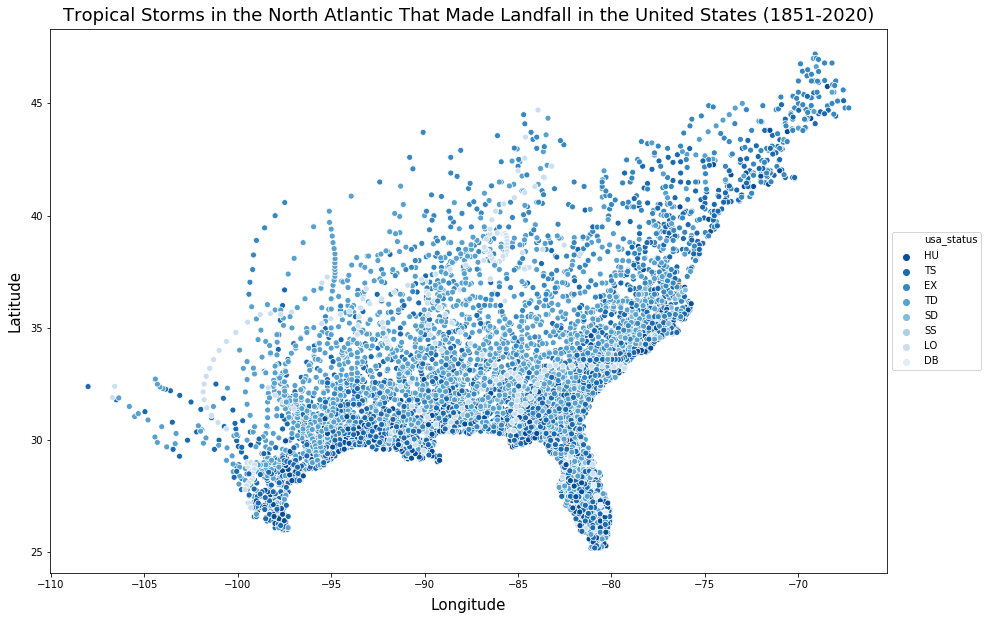

In [92]:
plt.figure(figsize= (15,10))
sns.scatterplot(x = 'longitude', y = 'latitude', hue = 'usa_status', data = geo_df_usa, palette = 'Blues_r', legend = 'full')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.title('Tropical Storms in the North Atlantic That Made Landfall in the United States (1851-2020)', fontdict = {'fontsize':18}, pad = 8)
plt.xlabel('Longitude', fontdict = {'fontsize':15}, labelpad = 8 )
plt.ylabel('Latitude', fontdict = {'fontsize':15}, labelpad = 8);

From the above plot of coordinates of storms, it is possible to see the outline of the United States. As indicated by the darker colors in these states, many stronger storms hit Florida, Louisiana, and Texas.

### Which states in the USA have experienced the most hurricanes?

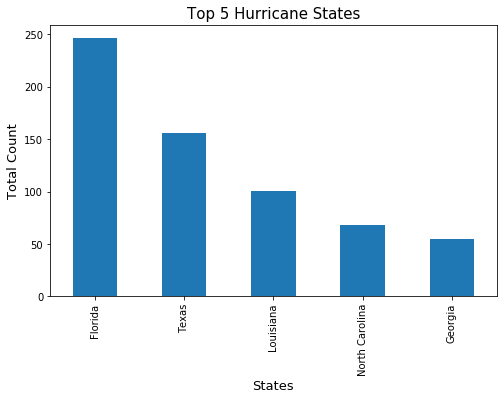

In [93]:
plt.figure(figsize = (8, 5))
hurricanes_and_covid.groupby('state')['hurricane_count'].agg('sum').sort_values(ascending=False).head().plot(kind='bar', title='Top 5 Hurricane States')
plt.title('Top 5 Hurricane States', fontdict = {'fontsize':15})
plt.xlabel('States', fontsize=13)
plt.ylabel('Total Count', fontsize=13);

This graph represents the top five states who have experienced the most hurricanes between 1851 and 2020.

### Which counties in the USA have experienced the most hurricanes?

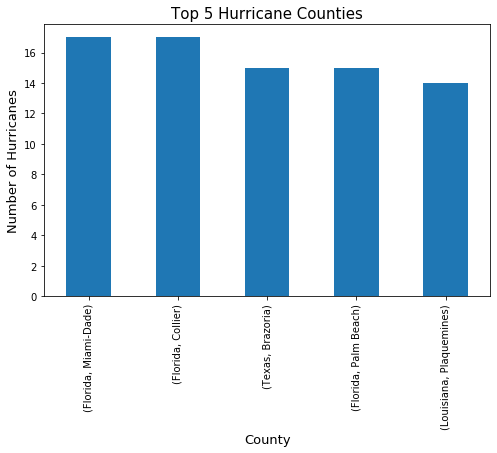

In [94]:
plt.figure(figsize = (8, 5))
hurricanes_and_covid.groupby(['state', 'county'])['hurricane_count'].agg('sum').sort_values(ascending=False).head().plot(kind='bar')
plt.title('Top 5 Hurricane Counties', fontdict = {'fontsize':15})
plt.xlabel('County', fontsize=13)
plt.ylabel('Number of Hurricanes', fontsize=13);

This graph represents the top five counties who have experienced the most hurricanes between 1851 and 2020.

### Which states historically impacted by tropical storms currently have the highest number of COVID-19 cases?

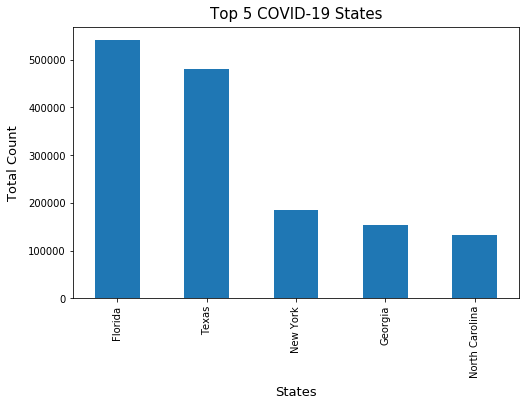

In [95]:
plt.figure(figsize = (8, 5))
hurricanes_and_covid.groupby('state')['current_cases'].agg('sum').sort_values(ascending=False).head().plot(kind='bar')
plt.title('Top 5 COVID-19 States', fontdict = {'fontsize':15}, pad = 8)
plt.xlabel('States', fontsize=13, labelpad = 8)
plt.ylabel('Total Count', fontsize=13, labelpad = 8);

This graph represents the top five states who have the most COVID-19 currently.

### Which counties in the US currently have the most COVID-19 case?

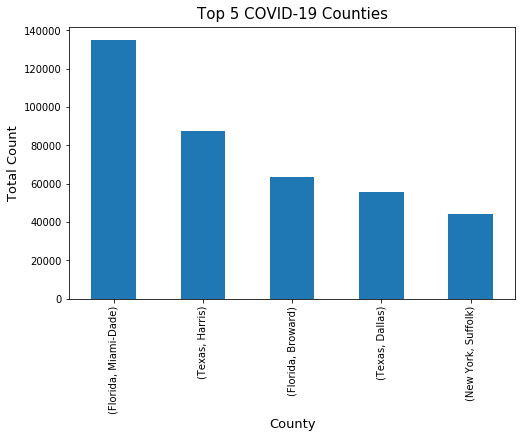

In [96]:
plt.figure(figsize = (8, 5))
hurricanes_and_covid.groupby(['state', 'county'])['current_cases'].agg('sum').sort_values(ascending=False).head().plot(kind='bar')
plt.title('Top 5 COVID-19 Counties', fontdict = {'fontsize':15}, pad = 8)
plt.xlabel('County', fontsize=13)
plt.ylabel('Total Count', fontsize=13);

This graph represents the states with the highest raw count of COVID-19 cases.

### How does the change in cases per 100,000 people compare by county?

#### Set - Up Plotting DF

In [97]:
usa_counties['total_fip'] = usa_counties['STATEFP'].astype(str) + usa_counties['COUNTYFP'].astype(str)
usa_fips = pd.merge(left = usa_counties, right = usa_states, how = 'left', left_on = 'STATEFP', right_on = 'STATE_FIPS')
usa_fips = usa_fips[['STATE_NAME', 'STATEFP', 'geometry_y', 'NAME', 'COUNTYFP', 'geometry_x',]].copy()
usa_fips.dropna(inplace = True) # Values correspond to Puerto Rico

In [99]:
plotting_df = pd.merge(left = hurricanes_and_covid, right = usa_fips, left_on = ['state', 'county'], right_on = ['STATE_NAME', 'NAME'])

plotting_df_abbrev = plotting_df[['state', 'county', 'geometry_x', 'change_in_case_ratio', 'STATEFP','COUNTYFP', 'storm_composite']]

plotting_df_abbrev['total_fips'] = plotting_df_abbrev['STATEFP'].astype(str) + plotting_df_abbrev['COUNTYFP'].astype(str)

#### Plot One-Week Change in Cases per 100,000 People

In [100]:
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
                  "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
                  "#08519c","#0b4083","#08306b"]

endpts = list(np.linspace(0, 500, len(colorscale) - 2))
fips = plotting_df_abbrev['total_fips'].tolist()
values = plotting_df_abbrev['change_in_case_ratio'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Weekly Change in COVID-19 Cases per 100,000 People (08/04/20 - 08/11/20)',
    legend_title='Cases per 100,000 People',
    round_legend_values=True
)

fig.layout.template = None
fig.show()

### How does our composite score map to counties?

In [101]:
# Code adapted from Plotly 

colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]

endpts = list(np.linspace(0, 50, len(colorscale) - 5))
fips = plotting_df_abbrev['total_fips'].tolist()
values = plotting_df_abbrev['storm_composite'].tolist()

fig = ff.create_choropleth(
    fips=fips, values=values,
    binning_endpoints=endpts,
    colorscale=colorscale,
    show_state_data=True,
    show_hover=True, centroid_marker={'opacity': 0},
    asp=2.9, title='Tropical Storm Composite Score by County',
    legend_title='Composite Score',
    round_legend_values=True)

fig.layout.template = None
fig.show()

Based on our previous explorations, we expect counties in Florida, Texas, and Louisiana to be hardest hit. We do see the darkest shades of blue (highest composite scores) in these counties.

## Model Preparation

When creating models to identify counties at risk for hurricanes and COVID-19, we found that including the composite score and change in cases per 100,000 resulted in the most interpretable clusters. Therefore, we will use these two features in our model.

#### Select Features

In [102]:
X = hurricanes_and_covid[['disturbance_composite', 'change_in_case_ratio']].dropna()

#### Scale Features

In [103]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)

## Modeling

### Functions

In [104]:
def km_grid_search(max_clusters, data):
    
    k_list = range(2,max_clusters)
    
    for k in k_list:
        km = KMeans(n_clusters = k, random_state = 42)
        km.fit(data)
        print(f'For k = {k}, the silhouette score is:')
        print(silhouette_score(X_scaled, km.labels_))
        print(f'For k = {k}, the inertia score is:')
        print(km.inertia_)
        print()

In [135]:
def dbs_grid_search(eps_list, min_samples_list, X):
    for epsilon in eps_list:
        for n in min_samples_list:
            dbs = DBSCAN(eps=epsilon, min_samples=n)
            dbs.fit(X)
            print(f'For eps = {epsilon} and min_samples = {n}, the silhouette score is:')
            print(silhouette_score(X, dbs.labels_))
            print()

In [105]:
def describe_cluster(cluster_num, feature_names, df = hurricanes_and_covid, cluster_col = 'cluster'):
    for col in feature_names:
        print(f'The mean for {col} is {df[df[cluster_col] == cluster_num][col].mean()}.')

### Initial Plot of Data

Text(0, 0.5, 'Change in Cases per 100,000 People')

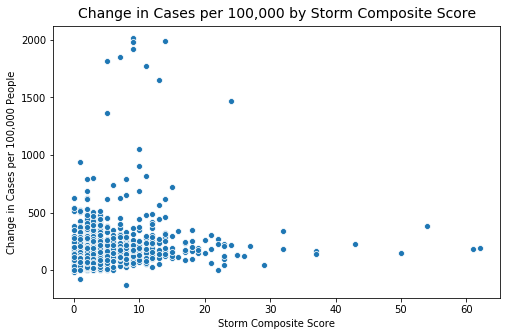

In [125]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'storm_composite', y = 'change_in_case_ratio', data = hurricanes_and_covid)
plt.title('Change in Cases per 100,000 by Storm Composite Score', fontdict = {'fontsize':14}, pad = 8)
plt.xlabel('Storm Composite Score')
plt.ylabel('Change in Cases per 100,000 People')

### K-Means Clustering

#### Grid Search

In [106]:
km_grid_search(15, X_scaled)

For k = 2, the silhouette score is:
0.6658894724011241
For k = 2, the inertia score is:
1967.3090182494475

For k = 3, the silhouette score is:
0.6045779166006638
For k = 3, the inertia score is:
1302.7099244736205

For k = 4, the silhouette score is:
0.5144235291780634
For k = 4, the inertia score is:
894.8737575630416

For k = 5, the silhouette score is:
0.5261731428448363
For k = 5, the inertia score is:
640.4604157365334

For k = 6, the silhouette score is:
0.45814907230169305
For k = 6, the inertia score is:
507.62109687592516

For k = 7, the silhouette score is:
0.47542108783891246
For k = 7, the inertia score is:
388.5589924126513

For k = 8, the silhouette score is:
0.41957888876352817
For k = 8, the inertia score is:
338.05997622003565

For k = 9, the silhouette score is:
0.42233149915693646
For k = 9, the inertia score is:
291.64581111845416

For k = 10, the silhouette score is:
0.4021617667792683
For k = 10, the inertia score is:
263.3277938475827

For k = 11, the silhouette

Based the balance of a moderate silhouette score and an okay inertia, we have decided to fit a model with 5 clusters.

#### Model

In [110]:
km = KMeans(n_clusters = 5, random_state = RANDOM_STATE)
km.fit(X_scaled)

hurricanes_and_covid['km_cluster'] = km.labels_

#### Confirm Matching Silhouette Score to Grid Search

In [138]:
silhouette_score(X_scaled, km.labels_)

0.5261731428448363

The silhouette score is 0.526. Given that a score of 1 indicates that a point is a perfect match to its own cluster and distanced from other clusters, this is a moderate score.

#### Check Cluster Value Counts

In [112]:
hurricanes_and_covid['km_cluster'].value_counts()

3    995
0    271
1    223
2     11
4     10
Name: km_cluster, dtype: int64

From the value counts, we can see that our data was clustered into uneven clusters. However, in comparison to other models that were built, this distribution of points across clusters is okay.

#### Plot Clusters

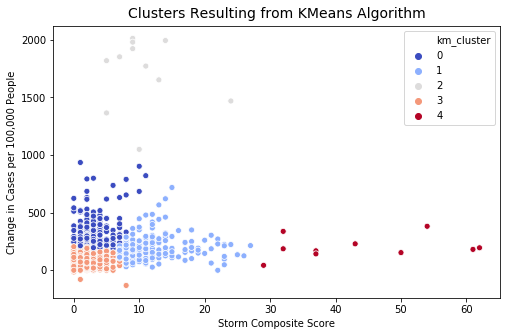

In [155]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = 'storm_composite', y = 'change_in_case_ratio', data = hurricanes_and_covid, hue = 'km_cluster', legend = 'full', palette = 'coolwarm')
plt.title('Clusters Resulting from KMeans Algorithm', fontdict = {'fontsize':14}, pad = 8)
plt.xlabel('Storm Composite Score')
plt.ylabel('Change in Cases per 100,000 People');

As shown in the plot above, the KMeans Algorithm identified 5 clusters:
* **Cluster 0:** Moderate Covid, Low Storm Composite
* **Cluster 1:** Moderate Covid, Low-Moderate Storm Composite
* **Cluster 2:** High Covid, Low-Moderate Storm Composite
* **Cluster 3:** Low Covid, Low Storm Composite
* **Cluster 4:** Low-Moderate Covid, High Storm Composite

### DBSCAN

Because our data does not show really good separation, we are also interested in building a DBSCAN to see how it will separate the data.

#### Grid Search

In [137]:
eps_list = [0.5, 0.75, 1, 1.5, 2]
min_samples = list(range(2,12))

dbs_grid_search(eps_list, min_samples, X_scaled)

For eps = 0.5 and min_samples = 2, the silhouette score is:
0.5870516963015137

For eps = 0.5 and min_samples = 3, the silhouette score is:
0.5874484043142739

For eps = 0.5 and min_samples = 4, the silhouette score is:
0.7998306280885167

For eps = 0.5 and min_samples = 5, the silhouette score is:
0.7998306280885167

For eps = 0.5 and min_samples = 6, the silhouette score is:
0.7981605388340309

For eps = 0.5 and min_samples = 7, the silhouette score is:
0.7883311132844479

For eps = 0.5 and min_samples = 8, the silhouette score is:
0.7808456966907276

For eps = 0.5 and min_samples = 9, the silhouette score is:
0.7764370651082404

For eps = 0.5 and min_samples = 10, the silhouette score is:
0.7698938081119838

For eps = 0.5 and min_samples = 11, the silhouette score is:
0.7650650477892679

For eps = 0.75 and min_samples = 2, the silhouette score is:
0.7865989929136188

For eps = 0.75 and min_samples = 3, the silhouette score is:
0.826686826413489

For eps = 0.75 and min_samples = 4, t

Based on the results of the grid search, we will build a model with `eps` = 2 and `min_samples` = 5. Even though it does not have the highest silhouette score, given the plot of our original data, it might be able to identify some of the points that are spread out from the largest conglomerate of points.

#### Model

In [148]:
dbs = DBSCAN(eps = 2, min_samples = 5)
dbs.fit(X_scaled)

hurricanes_and_covid['dbs_clusters'] = dbs.labels_

#### Check Silhouette Score

In [149]:
silhouette_score(X_scaled, dbs.labels_)

0.8608245946221224

#### Check Cluster Value Counts

In [150]:
hurricanes_and_covid['dbs_clusters'].value_counts()

 0    1497
 1       8
-1       5
Name: dbs_clusters, dtype: int64

From these value counts, we can see that the model was not really able to find any patterns in the data. 

#### Plot Clusters

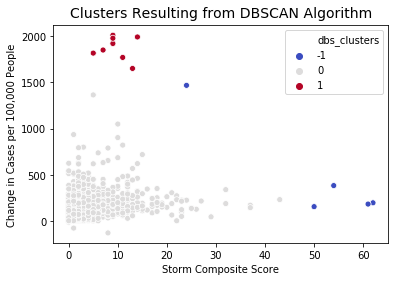

In [156]:
sns.scatterplot(x = 'storm_composite', y = 'change_in_case_ratio', data = hurricanes_and_covid, hue = 'dbs_clusters', legend = 'full', palette = 'coolwarm')
plt.title('Clusters Resulting from DBSCAN Algorithm', fontdict = {'fontsize':14}, pad = 8)
plt.xlabel('Storm Composite Score')
plt.ylabel('Change in Cases per 100,000 People');

From the above plot, we can see that the majority of our data points were clustered as low-medium Covid and low-medium storm composite. The highest levels of Storm Composite are being filtered out as noise.

## Model Selection

|Model|Number of Clusters|Silhouette Score|
|---|---|---|
|KMeans|5|0.526|
|DBSCAN|2|0.861|

Overall, we were surprised by the clusters that emerged from our models. When we first began the project, we were optimistic that a cluster that was high risk for COVID-19 and high risk for tropical storms would emerge. However, after exploring our data, we realized that severe hurricanes are not as common as we thought, and that the variation in COVID-19 cases was also less than expected.

However, given our options for models, due to it's ability to pick up on slight differences in current COVID-19 cases and historical risk of tropical storms, we will choose to further evaluate the KMeans clusters.

## Model Evaluation/ Interpretation